# CNN on Fashion-MNIST
Link: https://drive.google.com/drive/folders/1zKTc2r2Dp-cOVKOQ0K0h3Ug2AbgIKA9a?usp=drive_link

## Overview
The goal is to classify images of fashion items (e.g., shoes, shirts) into ten predefined classes from the Fashion-MNIST dataset.
Each image is a 28×28 grayscale image, and the task is to predict one of the 10 labels.

## Pre-Imported Libraries

In [1]:
import sys
import random
import platform
import torch
import numpy as np
import torchvision

## Step 1: Environment & Reproducibility
Check Python/PyTorch versions, device, and set random seeds for reproducibility.

In [2]:
print("Python:", sys.version.split()[0])
print("OS:", platform.platform())
print("PyTorch:", torch.__version__, "| TorchVision:", torchvision.__version__)

# Device selection: CUDA > MPS (Apple) > CPU
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

# Seeds
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if device == "cuda": torch.cuda.manual_seed_all(SEED)

Python: 3.11.9
OS: macOS-26.0.1-arm64-arm-64bit
PyTorch: 2.8.0 | TorchVision: 0.23.0
Device: mps


## Step 2: Define Hyperparameters
We define all key parameters in one place to make the experiment reproducible and easy to modify.
- `batch_size`: number of images per training batch
- `epochs`: number of passes through the dataset
- `lr`: learning rate
- `seed`: random seed for reproducibility

In [3]:
cfg = dict(
    batch_size = 64,
    epochs     = 5,
    lr         = 1e-3,
    num_workers= 0,
)

cfg

{'batch_size': 64, 'epochs': 5, 'lr': 0.001, 'num_workers': 0}

## Step 3: Load and Visualize the Dataset
This step loads the **Fashion-MNIST** dataset using `torchvision.datasets.FashionMNIST`.
The dataset contains 60,000 training and 10,000 test images in 10 classes:
- 0 = T-shirt/top
- 1 = Trouser
- 2 = Pullover
- 3 = Dress
- 4 = Coat
- 5 = Sandal
- 6 = Shirt
- 7 = Sneaker
- 8 = Bag
- 9 = Ankle boot

We will also display some sample images with their labels to understand the data.

In [22]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Basic transform: tensor + normalize to ~[-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_ds = datasets.FashionMNIST(root="./data", train=True,  download=True, transform=transform)
test_ds  = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=cfg["batch_size"], shuffle=True,
                          num_workers=cfg["num_workers"], pin_memory=(device=="cuda"))
test_loader  = DataLoader(test_ds,  batch_size=cfg["batch_size"], shuffle=False,
                          num_workers=cfg["num_workers"], pin_memory=(device=="cuda"))

class_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
               "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

len(train_ds), len(test_ds), class_names

(60000,
 10000,
 ['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'])

### Step 4 — Visualize a Few Samples
Confirm tensor shapes and labels to ensure the pipeline works.

Batch shape: torch.Size([64, 1, 28, 28]) Labels shape: torch.Size([64])


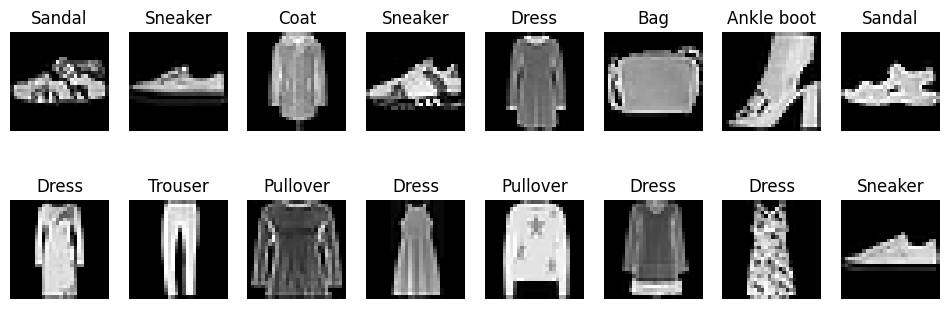

In [6]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))
print("Batch shape:", images.shape, "Labels shape:", labels.shape)  # [B,1,28,28], [B]

fig, axes = plt.subplots(2, 8, figsize=(12, 4))
for ax, img, lab in zip(axes.flat, images[:16], labels[:16]):
    ax.imshow(img.squeeze().numpy(), cmap="gray")
    ax.set_title(class_names[int(lab)])
    ax.axis("off")
plt.show()

## Step 5: How the CNN Algorithm Works in This Context

- **Inputs:** batches of images of shape `[B, 1, 28, 28]`
- **Initialization:** convolution filters and weights are randomly initialized
- **Loop:** for each batch, the model performs
  1. Convolution and ReLU to extract local features
  2. Pooling to downsample the feature maps
  3. Flattening and passing through fully connected layers
  4. Computing loss and backpropagating gradients
- **One iteration:** a single forward + backward pass that updates the weights
- **Termination:** after all epochs, training stops and the model is evaluated on the test set
- **Final result:** test accuracy and example predictions

Inputs `[B,1,28,28]` → Conv+ReLU → MaxPool → Conv+ReLU → MaxPool → Flatten → FC → logits (10).
Each training iteration: forward → compute cross-entropy loss → backward → optimizer step.
Termination after `epochs`; final result: test accuracy and sample predictions.

## Step 6: Define a Custom CNN Model
We implement a simple CNN manually using `torch.nn.Module`.
The model has:
- Two convolutional layers (`Conv2d`) with ReLU activation
- MaxPooling layers for downsampling
- A Flatten layer
- Fully connected layers for classification
We will also print the output shapes of each layer to understand how the data flows through the network.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)   # 28x28 -> 28x28
        self.pool  = nn.MaxPool2d(2, 2)                           # 28x28 -> 14x14
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 14x14 -> 14x14
        # pool -> 7x7
        self.fc1   = nn.Linear(64*7*7, 128)
        self.fc2   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> [B,32,14,14]
        x = self.pool(F.relu(self.conv2(x)))  # -> [B,64,7,7]
        x = torch.flatten(x, 1)               # -> [B,64*7*7]
        x = F.relu(self.fc1(x))
        x = self.fc2(x)                       # logits
        return x

model = SimpleCNN().to(device)
sum(p.numel() for p in model.parameters()), model

(421642,
 SimpleCNN(
   (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (fc1): Linear(in_features=3136, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=10, bias=True)
 ))

## Step 7: Loss Function and Optimizer
We use **CrossEntropyLoss**, which is suitable for multi-class classification problems.
The **Adam optimizer** is used to adjust the model parameters based on the gradients.

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=cfg["lr"])

## Step 8: Training Process — What Happens in Each Epoch
For each epoch:
1. Switch the model to training mode (`model.train()`)
2. For each batch:
   - Forward pass → compute predictions
   - Compute loss
   - Backward pass → compute gradients
   - Update parameters using the optimizer
3. Track training loss and accuracy for performance monitoring.

In [9]:
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    return total_loss/total, correct/total

## Step 9: Model Evaluation on Test Data
During evaluation:
- We set the model to evaluation mode (`model.eval()`)
- Disable gradient computation (`torch.no_grad()`)
- Compute predictions on the test set and calculate test accuracy.
The termination condition is when all test batches are processed.

In [10]:
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)
    return total_loss/total, correct/total

## Step 10: Run the Training and Validation Loops
We now combine the training and testing steps into a main loop.
For each epoch, we print the loss and accuracy for both training and test datasets.
This shows the model’s progress and whether it is overfitting or underfitting.

In [11]:
history = {"train_loss":[], "train_acc":[], "test_loss":[], "test_acc":[]}
best_acc, best_path = 0.0, "cnn_fashionmnist.pt"

for epoch in range(1, cfg["epochs"]+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, device)
    te_loss, te_acc = evaluate(model, test_loader, device)

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["test_loss"].append(te_loss);  history["test_acc"].append(te_acc)

    if te_acc > best_acc:
        best_acc = te_acc
        torch.save(model.state_dict(), best_path)

    print(f"Epoch {epoch:02d} | Train: loss={tr_loss:.4f} acc={tr_acc:.4f} | "
          f"Test: loss={te_loss:.4f} acc={te_acc:.4f} | Best acc={best_acc:.4f}")

best_acc

Epoch 01 | Train: loss=0.4379 acc=0.8425 | Test: loss=0.3618 acc=0.8703 | Best acc=0.8703
Epoch 02 | Train: loss=0.2755 acc=0.9004 | Test: loss=0.2720 acc=0.8994 | Best acc=0.8994
Epoch 03 | Train: loss=0.2289 acc=0.9171 | Test: loss=0.2451 acc=0.9111 | Best acc=0.9111
Epoch 04 | Train: loss=0.1978 acc=0.9270 | Test: loss=0.2400 acc=0.9140 | Best acc=0.9140
Epoch 05 | Train: loss=0.1708 acc=0.9374 | Test: loss=0.2296 acc=0.9202 | Best acc=0.9202


0.9202

## Step 11: Plot Learning Curves
We plot the training and test accuracy and loss over epochs to visualize how the model learns over time.

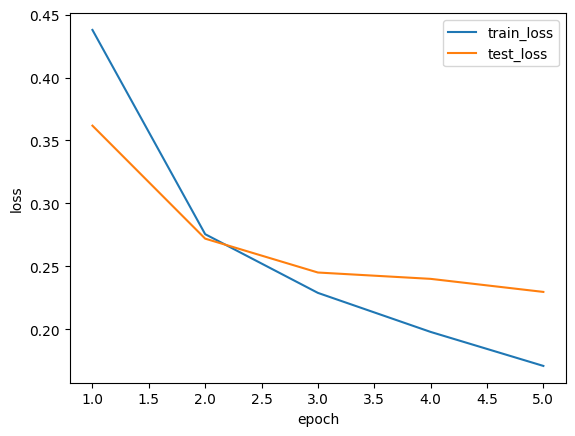

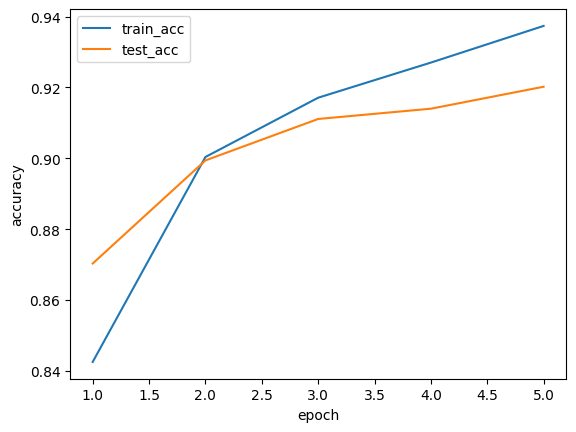

In [12]:
import matplotlib.pyplot as plt

epochs = range(1, cfg["epochs"]+1)
plt.figure(); plt.plot(epochs, history["train_loss"], label="train_loss")
plt.plot(epochs, history["test_loss"],  label="test_loss"); plt.legend(); plt.xlabel("epoch"); plt.ylabel("loss");
plt.show()

plt.figure(); plt.plot(epochs, history["train_acc"], label="train_acc")
plt.plot(epochs, history["test_acc"],  label="test_acc"); plt.legend(); plt.xlabel("epoch"); plt.ylabel("accuracy");
plt.show()

## Step 12: Final Evaluation and Metrics
We load the best model and test it again on the test dataset.
We report the final accuracy and can also display:
- Confusion matrix
- Classification report (precision, recall, F1-score)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# reload best weights
model.load_state_dict(torch.load("cnn_fashionmnist.pt", map_location=device))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y.numpy())

print("Final test accuracy:", (np.array(y_true)==np.array(y_pred)).mean())
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
cm

Final test accuracy: 0.9202
              precision    recall  f1-score   support

 T-shirt/top       0.88      0.87      0.87      1000
     Trouser       0.98      0.99      0.99      1000
    Pullover       0.87      0.89      0.88      1000
       Dress       0.88      0.95      0.91      1000
        Coat       0.89      0.86      0.87      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.81      0.73      0.77      1000
     Sneaker       0.95      0.98      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.98      0.95      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



array([[871,   3,  17,  23,   2,   1,  77,   0,   6,   0],
       [  0, 989,   0,   7,   0,   0,   3,   0,   1,   0],
       [ 14,   3, 892,  14,  39,   0,  37,   0,   1,   0],
       [  8,   8,   6, 953,   8,   0,  16,   0,   1,   0],
       [  1,   1,  42,  47, 862,   0,  43,   0,   4,   0],
       [  0,   0,   0,   0,   0, 985,   0,  13,   0,   2],
       [ 94,   2,  65,  39,  58,   0, 734,   0,   8,   0],
       [  0,   0,   0,   0,   0,   3,   0, 983,   0,  14],
       [  4,   2,   1,   5,   2,   2,   0,   3, 981,   0],
       [  0,   0,   0,   0,   0,   7,   1,  40,   0, 952]])

## Step 13: Visualize Predictions
We display several test images together with the predicted and true labels.
Incorrect predictions will be highlighted to show the model’s limitations.

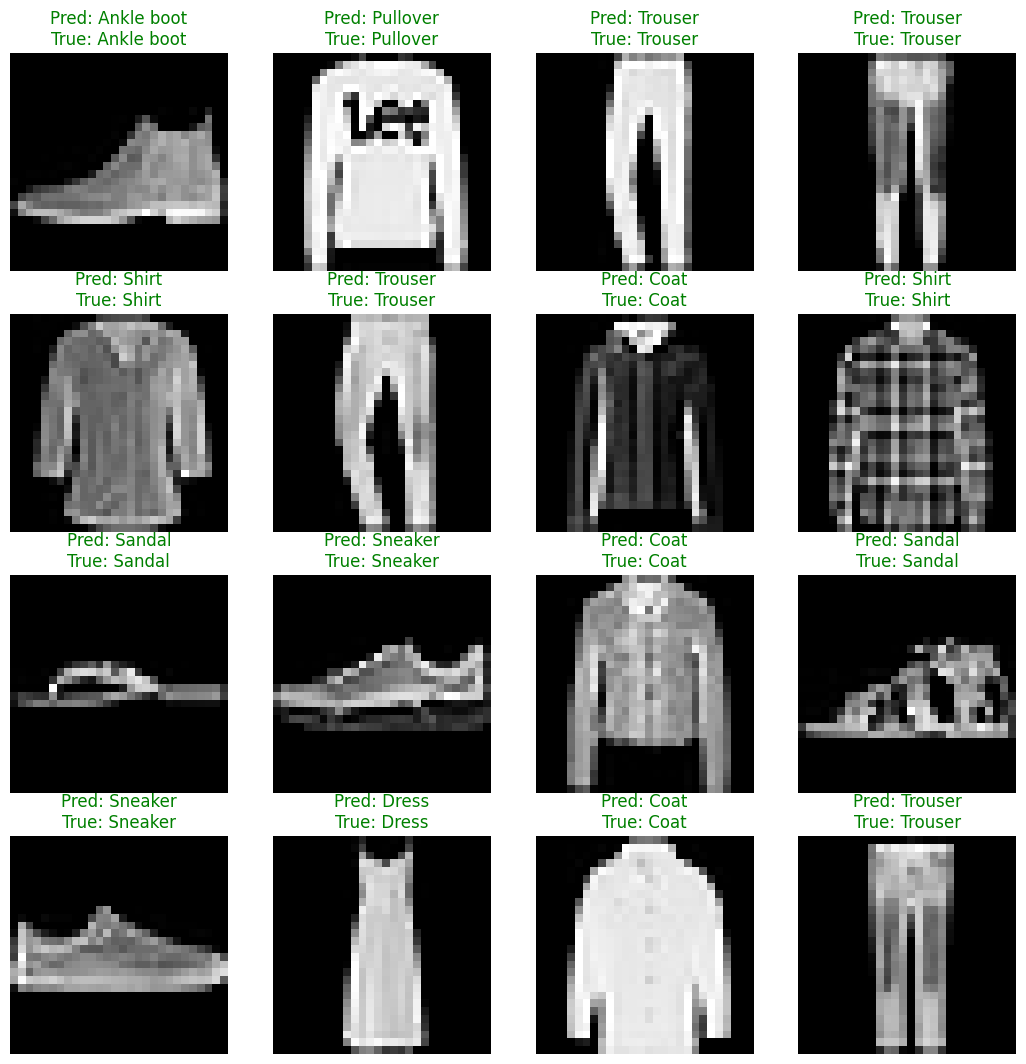

In [16]:
import matplotlib.pyplot as plt

def show_preds(n=16):
    model.eval()
    imgs, labs = next(iter(test_loader))
    with torch.no_grad():
        preds = model(imgs.to(device)).argmax(1).cpu()

    fig, axes = plt.subplots(4, 4, figsize=(13,13))
    for ax, img, lab, pr in zip(axes.flat, imgs[:n], labs[:n], preds[:n]):
        ax.imshow(img.squeeze().numpy(), cmap="gray")
        ax.set_title(f"Pred: {class_names[int(pr)]}\nTrue: {class_names[int(lab)]}",
                     color=("green" if pr==lab else "red"))
        ax.axis("off")
    plt.show()

show_preds()

### Step 14 — One Iteration in the Loop
Demonstrate one forward/backward/update step with shapes and loss value.

In [23]:
# Take a tiny batch
x, y = next(iter(train_loader))
x, y = x.to(device), y.to(device)

model.train()
optimizer.zero_grad()
logits = model(x)
loss = criterion(logits, y)
loss.backward()
optimizer.step()

print("x:", x.shape, "logits:", logits.shape, "loss:", float(loss))

x: torch.Size([64, 1, 28, 28]) logits: torch.Size([64, 10]) loss: 0.16131927073001862


## Step 15: Save and Load Model
We save the model weights using `torch.save()` and demonstrate how to reload them with `torch.load()`.
This ensures reproducibility and allows model reuse later.

In [18]:
torch.save(model.state_dict(), "cnn_fashionmnist_final.pt")

model2 = SimpleCNN().to(device)
model2.load_state_dict(torch.load("cnn_fashionmnist_final.pt", map_location=device))
model2.eval()

with torch.no_grad():
    x, y = next(iter(test_loader))
    preds = model2(x.to(device)).argmax(1).cpu()
    print("Sanity check — first 8 preds:", preds[:8].tolist())

Sanity check — first 8 preds: [9, 2, 1, 1, 6, 1, 4, 6]


## Step 16: Discussion and Conclusion
**Results:** Final test accuracy: 0.9202
**Strengths:** CNN automatically learns local spatial features, invariant to small translations
**Weaknesses:** Sensitive to rotation or scale; may confuse visually similar classes

**Possible improvements:**
- Add Dropout or Batch Normalization
- Use deeper architectures (AlexNet, ResNet, VGG)
- Apply data augmentation for better generalization